# Fruit Image Classification

##### import những libraries cần thiết.

In [1]:
import numpy as np # linear algebra
import pandas as pd # I/O of data
import matplotlib.pyplot as plt # making plots
%matplotlib inline
# keras for deep learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
#from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
#from sklearn.model_selection import train_test_split
from skimage import io
import os
import scipy.misc
from scipy.misc import imread, imresize
import csv
import random, shutil, zlib # directory operations
from glob import glob

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


##### Set path cho các directory

In [2]:
# First, look at everything.
from subprocess import check_output
print(check_output(["ls", "../input/fruits/fruits"]).decode("utf8"))

Real
Test
Train



In [3]:
# Training and testing folders
train_path = '../input/fruits/fruits/Train'
test_path = '../input/fruits/fruits/Test'
real_path = '../input/fruits/fruits/Real'

In [4]:
# Get train and test files
image_files = glob(train_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')
real_image_files = glob(real_path + '/*/*.jp*g')

##### Hiển thị thử 1 picture

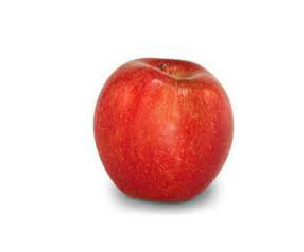

In [5]:
# Get number of classes
folders = glob(train_path + '/*')

# Display any random image
plt.imshow(plt.imread(np.random.choice(real_image_files)))
plt.axis('off')
plt.show()

##### Image Size: (100, 100), Size of each batch: 32

In [6]:
# Resize all the images to this
IMAGE_SIZE = [100, 100]
# Training config
batch_size = 32

##### To reduce over-fitting, we use another technique known as Data Augmentation. Data augmentation rotates, shears, zooms, etc the image so that the model learns to generalize and not remember specific data

In [7]:
# Create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  rescale=1./255
)

# Get label mapping of class and label number
test_gen = gen.flow_from_directory(test_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 5884 images belonging to 35 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Cantaloupe 1': 16, 'Cantaloupe 2': 17, 'Carambula': 18, 'Cherry 1': 19, 'Cherry 2': 20, 'Cherry Rainier': 21, 'Clementine': 22, 'Cocos': 23, 'Dates': 24, 'Granadilla': 25, 'Grape Pink': 26, 'Grape White': 27, 'Grape White 2': 28, 'Grapefruit Pink': 29, 'Grapefruit White': 30, 'Guava': 31, 'Huckleberry': 32, 'Kaki': 33, 'Kiwi': 34}


In [8]:
# Create generators for training and validation
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  test_path,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
)
real_generator = gen.flow_from_directory(
  real_path,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
)
output_units = len(test_gen.class_indices)
print(output_units)

Found 17516 images belonging to 35 classes.
Found 5884 images belonging to 35 classes.
Found 4 images belonging to 2 classes.
35


# Convolutional Neural Network

##### create the model

In [9]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (100, 100, 3), padding='same', use_bias=False))

#Set use_bias=False in layers.conv2d() and layers.dense()
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Conv2D(32, (3, 3), use_bias=False))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Conv2D(32, (3, 3), use_bias=False))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
# taking the 2-D array, i.e pooled image pixels and converting them to a one dimensional single vector.
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 256, kernel_initializer='he_normal', use_bias=False))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dropout(0.25))
classifier.add(Dense(units = output_units, activation = 'softmax', kernel_initializer='he_normal'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

##### #Epoches: 20

In [10]:
epochs_val = 20
validation_steps_val = len(test_image_files) // batch_size
steps_per_epoch_val = len(image_files) // batch_size

#steps_per_epoch: Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and 
#starting the next epoch. It should typically be equal to the number of samples of your dataset divided by the batch size. 

##### Training

In [11]:
classifier.fit_generator(train_generator, steps_per_epoch = steps_per_epoch_val, epochs = epochs_val, validation_data = valid_generator, validation_steps = validation_steps_val)

Epoch 1/20
547/547 [==============================] - 128s 234ms/step - loss: 0.4969 - acc: 0.8522 - val_loss: 0.4810 - val_acc: 0.8292
Epoch 2/20
547/547 [==============================] - 99s 182ms/step - loss: 0.1775 - acc: 0.9385 - val_loss: 0.2979 - val_acc: 0.9042
Epoch 3/20
547/547 [==============================] - 100s 182ms/step - loss: 0.1217 - acc: 0.9555 - val_loss: 0.4624 - val_acc: 0.8345
Epoch 4/20
547/547 [==============================] - 100s 183ms/step - loss: 0.1082 - acc: 0.9595 - val_loss: 0.1544 - val_acc: 0.9395
Epoch 5/20
547/547 [==============================] - 99s 180ms/step - loss: 0.0837 - acc: 0.9681 - val_loss: 0.0638 - val_acc: 0.9694
Epoch 6/20
547/547 [==============================] - 99s 181ms/step - loss: 0.0778 - acc: 0.9697 - val_loss: 0.2583 - val_acc: 0.9097
Epoch 7/20
547/547 [==============================] - 99s 180ms/step - loss: 0.0867 - acc: 0.9657 - val_loss: 0.1372 - val_acc: 0.9479
Epoch 8/20
547/547 [==============================] 

<b>Nhận Xét:</b> Sau 20 epoches model có độ chính xác 97.95% trên tập training và 96.99% trên tập validation

##### classifier report

In [12]:
predictions = classifier.predict_generator(valid_generator)
val_preds = np.argmax(predictions, axis=-1)
val_trues = valid_generator.classes
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_trues, val_preds, target_names = labels))

                     precision    recall  f1-score   support

     Apple Braeburn       0.99      0.96      0.98       164
     Apple Golden 1       1.00      1.00      1.00       164
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       1.00      1.00      1.00       161
 Apple Granny Smith       1.00      1.00      1.00       164
        Apple Red 1       1.00      0.90      0.95       164
        Apple Red 2       0.96      0.99      0.98       164
        Apple Red 3       0.90      1.00      0.95       144
Apple Red Delicious       1.00      1.00      1.00       166
   Apple Red Yellow       1.00      1.00      1.00       164
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe       1.00      1.00      1.00       166
             Banana       0.93      1.00      0.96       166
         Banana Red       0.99      1.00      0.99       166
       Cactus fruit    

<b>Nhận Xét: </b>Mô hình dự đoán tốt do hệ số F1 Score cao 0.97

##### predict on validation

In [13]:
# Visualizing predictions
result = np.round(classifier.predict_generator(valid_generator))

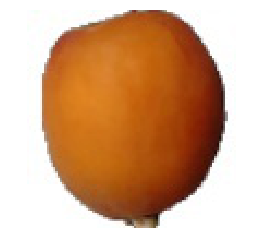

Actual class: Apricot
Predicted class: Apricot


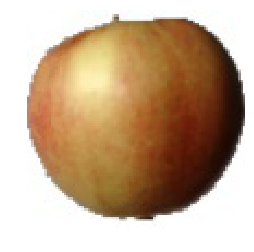

Actual class: Apple Red 2
Predicted class: Apple Red 2


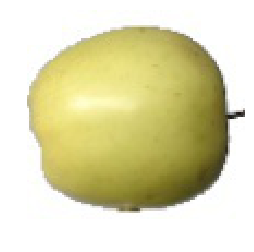

Actual class: Apple Golden 2
Predicted class: Apple Golden 2


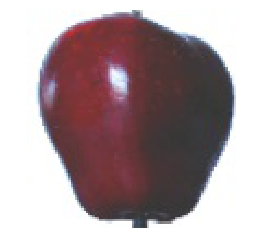

Actual class: Apple Red Delicious
Predicted class: Apple Red Delicious


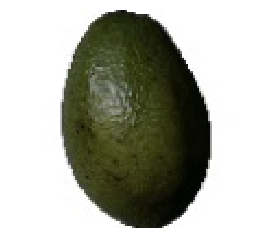

Actual class: Avocado
Predicted class: Avocado


In [15]:
import random
test_files = []
actual_res = []
test_res = []
for i in range(0, 5):
    rng = random.randint(0, len(valid_generator.filenames))
    test_files.append(test_path + '/' +  valid_generator.filenames[rng])
    actual_res.append(valid_generator.filenames[rng].split('/')[0])
    test_res.append(labels[np.argmax(result[rng])])
for i in range(0, 5):
    plt.imshow(plt.imread(test_files[i]))
    plt.axis('off')
    plt.show()
    print("Actual class: " + str(actual_res[i]))
    print("Predicted class: " + str(test_res[i]))

##### Predict on real picture

In [16]:
# Visualizing predictions
real_test_result = np.round(classifier.predict_generator(real_generator))

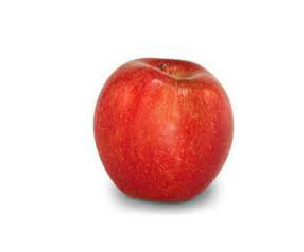

Actual class: Apple Braeburn
Predicted class: Kaki


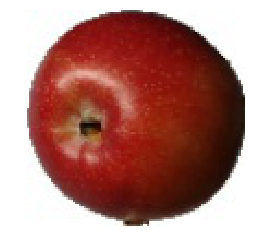

Actual class: Apple Braeburn
Predicted class: Apple Braeburn


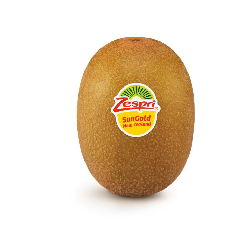

Actual class: Kiwi
Predicted class: Apple Red Yellow


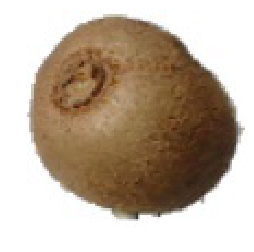

Actual class: Kiwi
Predicted class: Kiwi


In [18]:
for i in range(len(real_generator.filenames)):
    plt.imshow(plt.imread(real_path + '/' +  real_generator.filenames[i]))
    plt.axis('off')
    plt.show()
    print("Actual class: " + str(real_generator.filenames[i].split('/')[0]))
    print("Predicted class: " + str(labels[np.argmax(real_test_result[i])]))

<b>Nhận Xét:</b> Với các hình ảnh thực tế được lấy từ internet, hình ảnh này có chất lượng cao, model dự đoán ko có chính xác do những hình ảnh này có distribution khác với tập dữ liệu train và validation. Với các hình ảnh lấy ra từ tập test nhưng ko có đem đi làm tập validation, model dự đoán chính xác. 